# Comparison To Matricies from Jonathans Book / Notes ( Continous Beam )

Firstly we will compare the symbolic matricies with those created by Jonathan

## Preamble

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo
import FwtModels as mf

me.mechanics_printing()

## 1 Bending and 1 Torsion

Within Jonathans book (section 11.6) the following equation is 'derived' for a rectangluar wing with one mode in both bending and torsion

$m\left[\begin{array}{cc}{\frac{c s^{5}}{5}} & {\frac{s^{4}}{4}\left(\frac{c^{2}}{2}-c x_{\mathrm{f}}\right)} \\ {\frac{s^{4}}{4}\left(\frac{c^{2}}{2}-c x_{\mathrm{f}}\right)} & {\frac{s^{3}}{3}\left(\frac{c^{3}}{3}-c^{2} x_{\mathrm{f}}+c x_{\mathrm{f}}^{2}\right)}\end{array}\right]\left\{\begin{array}{c}{\dot{q}_{1}} \\ {\ddot{q}_{2}}\end{array}\right\}+\rho V\left[\begin{array}{cc}{\frac{c a_{\mathrm{WS}} 5}{10}} & {0} \\ {-\frac{c^{2} e a_{\mathrm{WS}}^{4}}{8}} & {-\frac{c^{3} s^{3} M_{\theta}}{24}}\end{array}\right]\left\{\begin{array}{c}{\dot{q}_{1}} \\ {\dot{q}_{2}}\end{array}\right\}+\left(\rho V^{2}\left[\begin{array}{cc}{0} & {\frac{c s^{4} a_{\mathrm{W}}}{8}} \\ {0} & {-\frac{e c^{2} s^{3} a_{W}}{6}}\end{array}\right]+\left[\begin{array}{cc}{4 E I s} & {0} \\ {0} & {G J s}\end{array}\right]\right)\left\{\begin{array}{l}{q_{1}} \\ {q_{2}}\end{array}\right\}=\left\{\begin{array}{l}{0} \\ {0}\end{array}\right\}$

Which is the explict version of this equation

$A \ddot{q}+(\rho v \mathbf{B}+\mathbf{D}) \dot{q}+\left(\rho v^{2} \mathbf{C}+\mathbf{E}\right) \boldsymbol{q}=0$

This is slightly different to I I have formulated the equations as my equation was

$\mathbf{A} \ddot{q}+\mathbf{K} q=\mathbf{B} \dot{q} + \mathbf{C} \dot{q}$

Which leads to:

$\mathbf{A} \ddot{q} - \mathbf{B} \dot{q}  +(\mathbf{K}-\mathbf{C}) q=0$

This section will aim to recreate each of these equations from my generalised model by setting the FWTD's size to 0

First, need to generate a symbolic model for the generalised case

In [8]:
b_modes = 3
t_modes = 2
modes = b_modes + t_modes
main_panels = 20
panels = main_panels

p = ma.DynamicModelParameters(modes)

## Create some global parameters
p.c = ma.ModelSymbol(value = 0.15,string = 'c') # chord of wing
p.s = ma.ModelSymbol(value = 1.345,string = 's_t') # total semi-span of wing
p.rho_t = ma.ModelSymbol(value = 19.53,string = 'rho_t') # per per unit area (kg/m^2)

p.b_modes = ma.ModelSymbol(value = b_modes,string = 'b_modes') # percentage of wing that is a FWT
p.t_modes = ma.ModelSymbol(value = t_modes,string = 't_modes') # percentage of wing that is a FWT

# Inner Wing stiffness Properties
p.EI = ma.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = ma.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

# Location of flexural axes
p.e_0 = ma.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f = ma.ModelSymbol(value = 0.08,string = 'x_f')

# Symbols to translate along inner wing and FWT
p.y_0 = sym.Symbol('y_0') # inner wing y chord
p.x_0 = sym.Symbol('x_0') # inner wing x chord

## Aero Parameters
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value = [0,0,-1],length=3,string='g_v')       # gravity vector
p.alpha_r = ma.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = ma.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term

## Main Wing Specific
p.a_i = ma.ModelSymbol(value = 2*np.pi,string = 'a_i')               # C_L slope of main wing
p.a_0i = ma.ModelSymbol(value = 2*np.pi,string = 'a_0i')               # C_L slope of main wing
p.a = ma.ModelMatrix(value =[np.pi*2]*panels,length=panels, string='a') # local C_l

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

# Factor to change the size of joint values
p.eta = ma.ModelMatrix(value = [1]*modes,length=modes,string='eta')

In [14]:
#get shape functions for main wing
z_0,tau_0 = ele.FlexiElement.ShapeFunctions_BN_TM(b_modes,t_modes,p.q,p.y_0,p.x_0,p.x_f,0,factor=p.eta,type='taylor')

# apply weighting function
#define wrefernce frames
wing_root_frame = ma.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f})

#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t)

wing_stiffness_ele = ele.FlexiElement(wing_frame,M_wing,p.x_0,p.y_0,(p.x_0,0,p.c),(p.y_0,0,p.s),p.x_f,p.EI,p.GJ,gravityPot=True)

In [15]:
# Main Wing Aero Forces 
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_flexural_frame,p.a_i,
                               alphadot = 0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               w_g = 0,
                               root_alpha = p.alpha_r,
                                delta_alpha = tau_0,
                               alpha_zero = 0,
                                stall_angle=0,
                               c = p.c,
                                V = p.V,
                                           c_d_max = 0,
                               linear = True,
                                z_inverted=False).integrate((p.y_0,0,p.s))

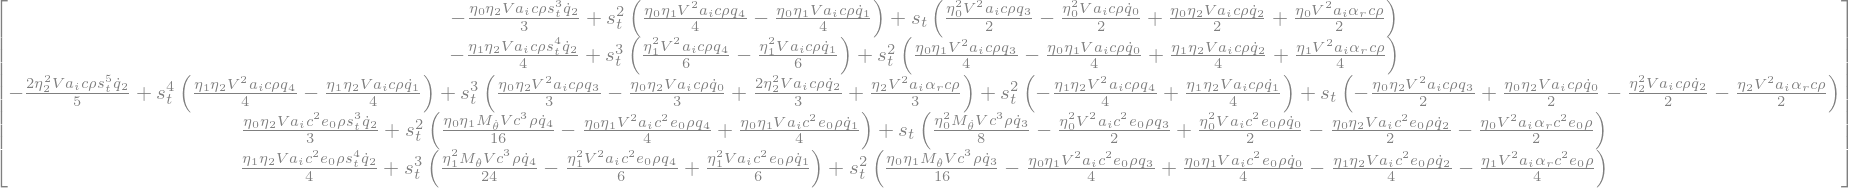

In [16]:
wing_AeroForces.Q()

In [17]:
sm = ma.SymbolicModel.FromElementsAndForces(p,[wing_stiffness_ele],wing_AeroForces).subs({i:1 for i in p.eta})
(A,B,C,D,E) = sm.extract_matrices(p)

0


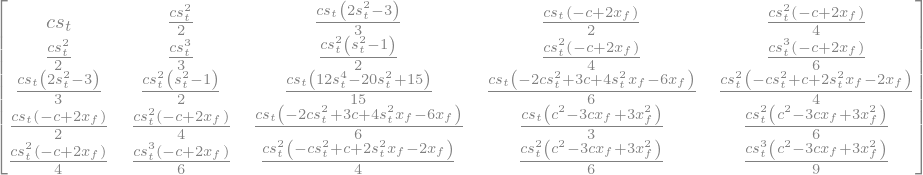

In [18]:
sym.simplify(A/p.rho_t)

for each matrix set $s_t$ to zero and print the result to compare with the original equation

comparing against the equation above:

$m\left[\begin{array}{cc}{\frac{c s^{5}}{5}} & {\frac{s^{4}}{4}\left(\frac{c^{2}}{2}-c x_{\mathrm{f}}\right)} \\ {\frac{s^{4}}{4}\left(\frac{c^{2}}{2}-c x_{\mathrm{f}}\right)} & {\frac{s^{3}}{3}\left(\frac{c^{3}}{3}-c^{2} x_{\mathrm{f}}+c x_{\mathrm{f}}^{2}\right)}\end{array}\right]\left\{\begin{array}{c}{\dot{q}_{1}} \\ {\ddot{q}_{2}}\end{array}\right\}+\rho V\left[\begin{array}{cc}{\frac{c a_{\mathrm{WS}} 5}{10}} & {0} \\ {-\frac{c^{2} e a_{\mathrm{WS}}^{4}}{8}} & {-\frac{c^{3} s^{3} M_{\theta}}{24}}\end{array}\right]\left\{\begin{array}{c}{\dot{q}_{1}} \\ {\dot{q}_{2}}\end{array}\right\}+\left(\rho V^{2}\left[\begin{array}{cc}{0} & {\frac{c s^{4} a_{\mathrm{W}}}{8}} \\ {0} & {-\frac{e c^{2} s^{3} a_{W}}{6}}\end{array}\right]+\left[\begin{array}{cc}{4 E I s} & {0} \\ {0} & {G J s}\end{array}\right]\right)\left\{\begin{array}{l}{q_{1}} \\ {q_{2}}\end{array}\right\}=\left\{\begin{array}{l}{0} \\ {0}\end{array}\right\}$

In [8]:
from IPython.display import display, Math, Latex
A_prime = sym.latex(sym.simplify(A/p.rho_t))
B_prime = sym.latex(sym.simplify(B/(p.rho*p.V)))
C_prime = sym.latex(sym.simplify(C/(p.rho*p.V**2)))
D_prime = sym.latex(sym.simplify(D))
E_prime = sym.latex(sym.simplify(-E))

q = '\\left\\{\\begin{array}{l}{q_{1}} \\\\ {q_{2}}\\end{array}\\right\\}'
qd = '\\dot{\\left\\{\\begin{array}{l}{q_{1}} \\\\ {q_{2}}\\end{array}\\right\\}}'
qdd = '\\ddot{\\left\\{\\begin{array}{l}{q_{1}} \\\\ {q_{2}}\\end{array}\\right\\}}'
zero = '\\left\\{\\begin{array}{l}{0} \\\\ {0}\\end{array}\\right\\}'

display(Latex(f'$$m{A_prime}{qdd} = \\rho V{B_prime}{qd} + \\left(\\rho V^2{C_prime} + {E_prime} \\right){q}$$'))

<IPython.core.display.Latex object>

Inspection shows all of these matrices are the same as that from the book with the exception of the aero damping matrix (bottum left reads a_w^4*s in the book which is a mistake as no mechanism in the maths can really raise a_w to the power of anything)

## 2 Bending and 2 Torsion

Within Jonathans book (section 11.6) the following equation is 'derived' for a rectangluar wing with one mode in both bending and torsion the LHS of the equation (free-bending problem) is:

$m\left[\begin{array}{ccc}
{\frac{s^{5} c}{5}} & {\frac{s^{6} c}{6}} & {\frac{s^{4}}{4}\left(\frac{c^{2}}{2}-c x_{f}\right)} & {\frac{s^{5}}{5}\left(\frac{c^{2}}{2}-c x_{f}\right)} \\
{\frac{s^{6} c}{6}} & {\frac{s^{7} c}{7}} & {\frac{s^{5} c}{5}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{6} c}{6}\left(\frac{c^{2}}{2}-c x_{i}\right)} \\
{\frac{s^{4}}{4}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{5}}{5}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{3}}{3}\left(\frac{c^{3}}{3}-c 2 x_{i}+c x_{i}^{2}\right)} & {\frac{s^{4}}{4}\left(\frac{c^{3}}{3}-c 2 x_{i}+c x_{i}^{2}\right)} \\
{\frac{s^{5}}{5}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{6}}{6}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{4}}{4}\left(\frac{c^{3}}{3}-c 2 x_{i}+c x_{f}^{2}\right)} & {\frac{s^{5}}{5}\left(\frac{c^{3}}{3}-c 2 x_{i}+c x_{f}^{2}\right)}
\end{array}\right]\mathbf{\ddot{q}} + \left[\begin{array}{cccc}
{4 \mathrm{EIs}} & {6 \mathrm{s}^{2} \mathrm{EI}} & {0} & {0} \\
{6 \mathrm{s}^{2} \mathrm{EI}} & {12 \mathrm{s}^{3} \mathrm{EI}} & {0} & {0} \\
{0} & {0} & {\mathrm{GJs}} & {\mathrm{GJs}^{2}} \\
{0} & {0} & {\mathrm{GJs}^{2}} & {\frac{4}{3} \mathrm{GJs}^{3}}
\end{array}\right]\mathbf{q} = \rho V\left[\begin{array}{cccc}{-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{5}}{10}} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{6}}{12}} & {0} & {0} \\ {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{6}}{12}} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{7}}{14}} & {0} & {0} \\ {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{4}}{8}} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{c}} \mathrm{s}^{5}}{10}} & {\frac{\mathrm{c}^{3} \mathrm{M}_{6} \mathrm{s}^{3}}{24}} & {\frac{\mathrm{c}^{3} \mathrm{M}_{6} \mathrm{s}^{4}}{32}} \\ {\frac{\mathrm{c}^{2} \mathrm{ea}_{0}}{10}} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{0} \mathrm{s}^{6}}{12}} & {\frac{\mathrm{c}^{3} \mathrm{M}_{6} \mathrm{s}^{4}}{32}} & {\frac{\mathrm{c}^{3} \mathrm{M}_{6} \mathrm{s}^{5}}{40}}\end{array}\right]\mathbf{\dot{q}} + \rho V^{2}\left[\begin{array}{cccc}
{0} & {0} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{4}}{8}} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{5}}{10}} \\
{0} & {0} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{5}}{10}} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{6}}{12}} \\
{0} & {0} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{3}}{6}} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{4}}{8}} \\
{0} & {0} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{4}}{8}} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{5}}{10}}
\end{array}\right]\mathbf{q}$

recreating this with my library


In [9]:
b_modes = 2
t_modes = 2
modes = b_modes + t_modes
main_panels = 20
panels = main_panels

p = ma.DynamicModelParameters(modes)

## Create some global parameters
p.c = ma.ModelSymbol(value = 0.15,string = 'c') # chord of wing
p.s = ma.ModelSymbol(value = 1.345,string = 's_t') # total semi-span of wing
p.rho_t = ma.ModelSymbol(value = 19.53,string = 'rho_t') # per per unit area (kg/m^2)

p.b_modes = ma.ModelSymbol(value = b_modes,string = 'b_modes') # percentage of wing that is a FWT
p.t_modes = ma.ModelSymbol(value = t_modes,string = 't_modes') # percentage of wing that is a FWT

# Inner Wing stiffness Properties
p.EI = ma.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = ma.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

# Location of flexural axes
p.e_0 = ma.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f = ma.ModelSymbol(value = 0.08,string = 'x_f')

# Symbols to translate along inner wing and FWT
p.y_0 = sym.Symbol('y_0') # inner wing y chord
p.x_0 = sym.Symbol('x_0') # inner wing x chord

## Aero Parameters
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value = [0,0,-1],length=3,string='g_v')       # gravity vector
p.alpha_r = ma.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = ma.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term

## Main Wing Specific
p.a_i = ma.ModelSymbol(value = 2*np.pi,string = 'a_i')               # C_L slope of main wing
p.a_0i = ma.ModelSymbol(value = 2*np.pi,string = 'a_0i')               # C_L slope of main wing
p.a = ma.ModelMatrix(value =[np.pi*2]*panels,length=panels, string='a') # local C_l

## Numeric Model Constants
p.fp = ma.ModelMatrix(value =[0]*p.qs*2,length=p.qs*2,string='fp') # The stationary point

# Factor to change the size of joint values
p.eta = ma.ModelMatrix(value = [1]*modes,length=modes,string='eta')

for each matrix set $s_t$ to zero and print the result to compare with the original equation

In [10]:
#get shape functions for main wing
z_0,tau_0 = ele.FlexiElement.ShapeFunctions_BN_TM(b_modes,t_modes,p.q,p.y_0,p.x_0,p.x_f,0,factor=p.eta)

# apply weighting function
#define wrefernce frames
wing_root_frame = ma.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f})

#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t)

wing_stiffness_ele = ele.FlexiElement(wing_frame,M_wing,p.x_0,p.y_0,(p.x_0,0,p.c),(p.y_0,0,p.s),p.x_f,p.EI,p.GJ,gravityPot=True)

In [11]:
# Main Wing Aero Forces 
wing_AeroForces = ef.AeroForce.PerUnitSpan(p,wing_flexural_frame,p.a_i,
                               alphadot = 0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               w_g = 0,
                               root_alpha = 0,
                                delta_alpha = tau_0,
                               alpha_zero = 0,
                                stall_angle=0,
                               c = p.c,
                                V = p.V,
                                c_d_max = 0,
                               linear = True,
                                z_inverted=False).integrate((p.y_0,0,p.s))

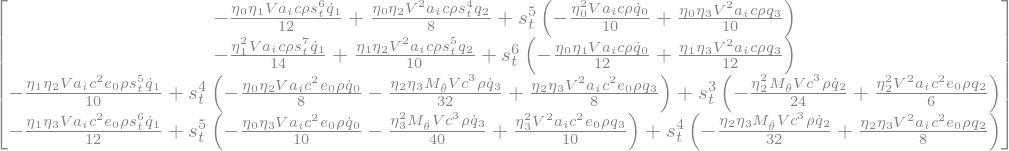

In [12]:
wing_AeroForces.Q()

In [13]:
sm = ma.SymbolicModel.FromElementsAndForces(p,[wing_stiffness_ele],wing_AeroForces).subs({i:1 for i in p.eta})
(A,B,C,D,E) = sm.extract_matrices(p)

0


In [14]:
from IPython.display import display, Math, Latex
A_prime = sym.latex(sym.simplify(A/p.rho_t))
B_prime = sym.latex(sym.simplify(B/(p.rho*p.V)))
C_prime = sym.latex(sym.simplify(C/(p.rho*p.V**2)))
D_prime = sym.latex(sym.simplify(D))
E_prime = sym.latex(sym.simplify(E))

q = '\\vec{q}'
qd = '\\dot{\\vec{q}}'
qdd = '\\ddot{\\vec{q}}'
zero = '\\vec{0}'

display(Latex(f'$$m{A_prime}{qdd} + {E_prime}{q} = \\rho V{B_prime}{qd} + \\left(\\rho V^2{C_prime} \\right){q}$$'))

<IPython.core.display.Latex object>

As a reminded Jonathan's equations were

$m\left[\begin{array}{ccc}
{\frac{s^{5} c}{5}} & {\frac{s^{6} c}{6}} & {\frac{s^{4}}{4}\left(\frac{c^{2}}{2}-c x_{f}\right)} & {\frac{s^{5}}{5}\left(\frac{c^{2}}{2}-c x_{f}\right)} \\
{\frac{s^{6} c}{6}} & {\frac{s^{7} c}{7}} & {\frac{s^{5} c}{5}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{6} c}{6}\left(\frac{c^{2}}{2}-c x_{i}\right)} \\
{\frac{s^{4}}{4}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{5}}{5}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{3}}{3}\left(\frac{c^{3}}{3}-c 2 x_{i}+c x_{i}^{2}\right)} & {\frac{s^{4}}{4}\left(\frac{c^{3}}{3}-c 2 x_{i}+c x_{i}^{2}\right)} \\
{\frac{s^{5}}{5}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{6}}{6}\left(\frac{c^{2}}{2}-c x_{i}\right)} & {\frac{s^{4}}{4}\left(\frac{c^{3}}{3}-c 2 x_{i}+c x_{f}^{2}\right)} & {\frac{s^{5}}{5}\left(\frac{c^{3}}{3}-c 2 x_{i}+c x_{f}^{2}\right)}
\end{array}\right]\mathbf{\ddot{q}} + \left[\begin{array}{cccc}
{4 \mathrm{EIs}} & {6 \mathrm{s}^{2} \mathrm{EI}} & {0} & {0} \\
{6 \mathrm{s}^{2} \mathrm{EI}} & {12 \mathrm{s}^{3} \mathrm{EI}} & {0} & {0} \\
{0} & {0} & {\mathrm{GJs}} & {\mathrm{GJs}^{2}} \\
{0} & {0} & {\mathrm{GJs}^{2}} & {\frac{4}{3} \mathrm{GJs}^{3}}
\end{array}\right]\mathbf{q} = \rho V\left[\begin{array}{cccc}{-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{5}}{10}} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{6}}{12}} & {0} & {0} \\ {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{6}}{12}} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{7}}{14}} & {0} & {0} \\ {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{4}}{8}} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{c}} \mathrm{s}^{5}}{10}} & {\frac{\mathrm{c}^{3} \mathrm{M}_{6} \mathrm{s}^{3}}{24}} & {\frac{\mathrm{c}^{3} \mathrm{M}_{6} \mathrm{s}^{4}}{32}} \\ {\frac{\mathrm{c}^{2} \mathrm{ea}_{0}}{10}} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{0} \mathrm{s}^{6}}{12}} & {\frac{\mathrm{c}^{3} \mathrm{M}_{6} \mathrm{s}^{4}}{32}} & {\frac{\mathrm{c}^{3} \mathrm{M}_{6} \mathrm{s}^{5}}{40}}\end{array}\right]\mathbf{\dot{q}} + \rho V^{2}\left[\begin{array}{cccc}
{0} & {0} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{4}}{8}} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{5}}{10}} \\
{0} & {0} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{5}}{10}} & {-\frac{\mathrm{ca}_{\mathrm{w}} \mathrm{s}^{6}}{12}} \\
{0} & {0} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{3}}{6}} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{4}}{8}} \\
{0} & {0} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{4}}{8}} & {\frac{\mathrm{c}^{2} \mathrm{ea}_{\mathrm{w}} \mathrm{s}^{5}}{10}}
\end{array}\right]\mathbf{q}$

A comparison of the two equations shows they are exactly the same except for a $c2$ term in each of the terms M[2:,2:] in Jonathans which are a $c^2$ in mine

Looking at were these are derived from in Jonathans, namely:

$\frac{\mathrm{d}}{\mathrm{dt}}\left(\frac{\partial T}{\partial \dot{q}_{4}}\right)=m\left[\frac{s^{5}}{5}\left(\frac{c^{2}}{2}-\alpha_{t}\right) \ddot{\mathrm{q}}_{1}+\frac{s^{6}}{6}\left(\frac{\mathrm{c}^{2}}{2}-\mathrm{cx}_{t}\right) \ddot{\mathrm{q}}_{2}+\frac{\mathrm{s}^{4}}{4}\left(\frac{\mathrm{c}^{3}}{3}-\mathrm{c}^{2} \mathrm{x}_{\mathrm{f}}+\mathrm{cx}_{\mathrm{f}}^{2}\right) \ddot{\mathrm{q}}_{3}+\frac{\mathrm{s}^{5}}{5}\left(\frac{\mathrm{c}^{3}}{3}-\mathrm{c}^{2} \mathrm{x}_{\mathrm{t}}+\mathrm{cx}_{\mathrm{f}}^{2}\right) \ddot{\mathrm{q}}_{4}\right]$

it is clear this is just an presentation error in the final matrix, and it should infact be $c^2$

## Test a couple of Numeric Models

### Compare Frequency values for a SDoF system

with Jonathan's book, in section 3.2.1, a model is built of a continous wing with a single assumed shape:

$z(y, t)=\psi(y) q(t)=\left(\frac{y}{s}\right)^{2} q(t)$

The natural frequency of this system is found to be $\omega=4.47 \sqrt{\frac{E I}{\mu s^{4}}}$ and the exact answer is shown as $\omega=3.516 \sqrt{\frac{E I}{\mu s^{4}}}$

#### Compare model with the answer for one assumed shape in bending

In [15]:
# create generalised coordinates
q0 = me.dynamicsymbols('q0') 
q = sym.Matrix([q0])

# create instance of Fwt parameters
p = AssumedShapes.FwtParameters()
p.ThetaLocked = True

# define shape Functions
z_w = q0*y**2
alpha_w = sym.Rational(0,1)

# FWT is locked so is parrallel to the end of the main wing
z_t = z_w.subs(y,p.s_w) + z_w.diff(t).subs(y,p.s_w)*y
alpha_t = alpha_w.subs(y,p.s_w)

# create the model
sModel = AssumedShapes.SymbolicModel(q,z_w,alpha_w,z_t,alpha_t,p)
sModel.GenerateEoM()

eSet = (sModel.M**-1*sModel.K).eigenvals()
eVal = sym.sqrt(((eSet.popitem())[0]).subs({p.k_theta:0,p.s_t:0}))
eVal

NameError: name 'AssumedShapes' is not defined

#### What about 2 shapes for bending

In [ ]:
# create generalised coordinates
q0,q1 = me.dynamicsymbols('q0,q1') 
q = sym.Matrix([q0,q1])

# create instance of Fwt parameters
p = AssumedShapes.FwtParameters()
p.ThetaLocked = True

# define shape Functions
z_w = q0*y**2+q1*y**3
alpha_w = sym.Rational(0,1)

# FWT is locked so is parrallel to the end of the main wing
z_t = z_w.subs(y,p.s_w) + z_w.diff(t).subs(y,p.s_w)*y
alpha_t = alpha_w.subs(y,p.s_w)

# create the model
sModel = AssumedShapes.SymbolicModel(q,z_w,alpha_w,z_t,alpha_t,p)
sModel.GenerateEoM()



eSet = (sModel.M**-1*sModel.K).eigenvals()
freqs = []
for key,value in eSet.items():
    freqs.append(sym.simplify(sym.sqrt(key.subs({p.k_theta:0,p.s_t:0}))))
freqs

Thats getting more complicated and doesnt really simplify well. So lets swap to numerical analysis.


If we set $E,I,m_w,s_w,c$ to 1 the frequecy of the lowest mode shape should start at 4.47 and tend to 3.516

In [ ]:
# create generalised coordinates
q0,q1,q2 = me.dynamicsymbols('q:3') 
q = sym.Matrix([q0,q1,q2])

# create instance of Fwt parameters
p = AssumedShapes.FwtParameters()
p.ThetaLocked = True
p.EI.value = 1
p.m_w.value = 1
p.s_w.value = 1
p.c.value = 1


# created assumed shapes for ever higher order models then create a numerical model and find the minimium modal frequency
Freqs = []
Vecs = []
Df = pd.DataFrame();
for i in np.arange(0,3):
    # define shape Functions
    z_w = sym.Rational(0,1)
    for j in np.arange(0,i+1):
        z_w = z_w + q[j]*y**(2+j)

    alpha_w = sym.Rational(0,1)

    # FWT is locked so is parrallel to the end of the main wing
    z_t = z_w.subs(y,p.s_w) + z_w.diff(t).subs(y,p.s_w)*y
    alpha_t = alpha_w.subs(y,p.s_w)

    # create the model
    sModel = AssumedShapes.SymbolicModel(q,z_w,alpha_w,z_t,alpha_t,p)
    sModel.GenerateEoM()

    nModel = sModel.createNumericInstance()

    df = nModel.FreeVibrationValsPd()
    withS = 's' if i>0 else ''
    df['Shapes'] = f'{i+1} Shape{withS}'
    df['Mode'] = df.index
    Df = pd.concat((Df,df),axis=0)

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
Df['% Error'] = ((Df['Freq'] / 3.516) -1)*100

In [ ]:
# plot mode shapes
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# make a data frame to calulaate the positon at each y station
ModeDf = pd.DataFrame()
ModeDf['y'] = np.linspace(0,1,100)
ShapeDf = Df[Df['Mode']==0].reset_index(drop=True)
# make a new series for each MOde shape to show as a combination of the values in ShapeDf
for i in np.arange(0,3):
    ModeDf[f'Mode Shape ({i+1} Shape)'] = ModeDf['y'] **2 * ShapeDf['Comp 0'][i] + ModeDf['y'] **3 * ShapeDf['Comp 1'][i] + ModeDf['y'] **4 * ShapeDf['Comp 2'][i]

# set the index of the data frame
ModeDf = ModeDf.set_index('y')

# ensure the end of the beam is deflecting up
cols = list(ModeDf)
for i in range(0,len(cols)):
    if ModeDf[cols[i]].iloc[-1] < 0:
        ModeDf[cols[i]] = ModeDf[cols[i]]*-1

#normalise shapes to max value
ModeDf = ModeDf.apply(lambda x : x/x.max())

sns.lineplot(data = ModeDf)
